In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import sklearn.linear_model as lm
import pandas as pd
from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, 
                           title, subplot, show, grid)
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, confusion_matrix
import pickle
from scipy.linalg import svd
import seaborn as sn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter
from torch.autograd import Variable

In [ ]:
from google.colab import drive #For google colab integration
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First we load the data:


In [ ]:
!pip3 install pickle5
import pickle5 as pickle
# df = pd.read_csv('/content/drive/MyDrive/Computational Tools/final_df234.csv')
with open('/content/drive/MyDrive/Computational_Tools/final_df234.pickle', 'rb') as f:
  df = pickle.load(f)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
n = 1500000 #Sample size
df_subset = df.sample(n).copy()
#split into data and targets:
X = df_subset.drop(columns = ['Severity']).copy() 
y = df_subset['Severity']

In [ ]:
#Normalize data
normalized_df=(X-X.mean())/X.std()

#Split data into training(95%), validation(2.5%) and test split(2.5%):
X_train, X_rem, y_train, y_rem = train_test_split(X,y,train_size = 0.95)

X_test, X_val, y_test, y_val = train_test_split(X_rem,y_rem, test_size=0.5)

#the data set contains far more datapoints of severity 2 then the other values, making severity 2 the most common category. 
#To avoid this messing with the outcome, we try undersampling classes Severity 2 and 3, and oversampling category 1.
train_data = pd.concat([X_train, y_train], axis=1)

#Separate the dataset by class
Sev1 = train_data[train_data.Severity==1]
Sev2 = train_data[train_data.Severity==2]
Sev3 = train_data[train_data.Severity==3]
Sev4 = train_data[train_data.Severity==4]
Majority_list = [Sev1,Sev2,Sev3]
#Set over and undersampling ratios
# over_under_size = [int(a*(len(Sev4)/50000)) for a in [10000,100000,70000]]
over_under_size = [len(Sev4),len(Sev4),len(Sev4)]
downsampled = Sev4
for i in range(len(Majority_list)):
  Maj_downsampled = resample(Majority_list[i], replace=True,  n_samples=over_under_size[i], random_state=27) #resample data
  downsampled = pd.concat([downsampled,Maj_downsampled],axis=0)
#Set data to tensors of correct datatype:
X_train = torch.Tensor(downsampled.drop(columns = ["Severity"]).copy().values).type(torch.float64)
y_train = torch.Tensor(downsampled['Severity'].values).type(torch.LongTensor)-1
X_test = torch.Tensor(X_test.values).type(torch.float64)
X_val = torch.Tensor(X_val.values).type(torch.float64)
y_test = torch.Tensor(y_test.values)-1
y_val = torch.Tensor(y_val.values)-1


In [ ]:
#Check the size of the training and validation set:
print(len(X_train),len(y_val))

173580 37500


We can check if the data can predict the class label with a simple linear regression. We do this to get an idea of how difficult the problem is to solve.

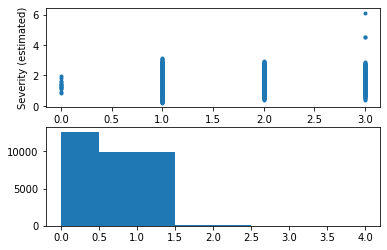

array([0.57408723, 0.83238448, 0.57684864, ..., 0.11786785, 0.7884346 ,
       0.65573032])

In [ ]:
#We use an sklearn implementation of linear regression since we only want to check if the problem is easily solvable:
model = lm.LinearRegression()
model.fit(X_train,y_train)

# Predict alcohol content
y_est = model.predict(X_test)
residual = y_est-y_test.numpy()

# Display scatter plot
figure()
subplot(2,1,1)
plt.plot(y_test, y_est, '.')
plt.xlabel('Severity (true)'); plt.ylabel('Severity (estimated)');
  
subplot(2,1,2)
plt.hist(residual,bins=[0,0.5,1.5,2.5,3.5,4])

show()

The problem is not easily solved, since the linear regression cannot distinguish between the classes

Below we build the network(adapted from 02456 exercise 3.3 2021)

In [ ]:
#Hyperparameters
num_output = 4
num_l1 = 1024
num_l2 = 2048
num_features = X_train.shape[1]

# define network
class Net(nn.Module):
  def __init__(self,num_features, num_hidden, num_hidden_2, num_output):
    super(Net, self).__init__()
    self.linear1 = nn.Linear(num_features,num_l1)
    self.linear2 = nn.Linear(num_l1,num_l2)
    self.linear3 = nn.Linear(num_l2,num_l1)
    self.linear4 = nn.Linear(num_l1,num_output)
    # self.linear3 = nn.Linear(num_l2,num_output)


    # self.activation = torch.nn.Tanh()
    self.activation = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout(p=0.6)
    self.batchnorm1 = torch.nn.BatchNorm1d(num_hidden)
    self.batchnorm2 = torch.nn.BatchNorm1d(num_hidden_2)

  def forward(self, x):
    x = self.linear1(x)
    x = self.dropout(x)
    x = self.activation(x)
    x = self.batchnorm1(x)
    x = self.linear2(x)
    x = self.dropout(x)
    x = self.activation(x)
    x = self.batchnorm2(x)
    x = self.linear3(x)
    x = self.dropout(x)
    x = self.batchnorm1(x)
    x = self.linear4(x)
    return F.softmax(x,dim=1)

net = Net(num_features, num_l1, num_l2, num_output).double()

if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()
print(net)

##converting network to cuda-enabled
Net(
  (linear1): Linear(in_features=91, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2048, bias=True)
  (linear3): Linear(in_features=2048, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=4, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.6, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
#Define the optimizer and criterion(Loss function)
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss()


Below we have the training loop for the network (adapted from 02456 exercise 3.3)
In order to run this code, cuda will have to be available on your machine. Otherwise it can run on google colab using a GPU runtime.

In [ ]:


# setting hyperparameters and gettings epoch sizes
batch_size = 4096
num_epochs = 100
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):


        slce = get_slice(i, batch_size)
        input = X_train[slce].cuda()
        # input = input.cuda()
        output = net(input)
        
        # compute gradients given loss
        target_batch = y_train[slce]
        target_batch = target_batch.cuda()
        batch_loss = criterion(output, target_batch)
        # batch_loss.requires_grad=True
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss  
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        input = X_train[slce].cuda()
        output = net(input)
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(y_train[slce].cpu().numpy())
        train_preds += list(preds.data.cpu().numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        input = X_val[slce].cuda()
        output = net(input)
        preds = torch.max(output, 1)[1]
        val_targs += list(y_val[slce].cpu().numpy())
        val_preds += list(preds.data.cpu().numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Epoch  1 : Train Loss 0.014451 , Train acc 0.361654, Valid acc 0.230496
Epoch 11 : Train Loss 0.012150 , Train acc 0.250535, Valid acc 0.031386
Epoch 21 : Train Loss 0.011438 , Train acc 0.251657, Valid acc 0.033176


KeyboardInterrupt: ignored

Please not that due to the randomness involved in sampling data points, splitting the dataset and initializing parameters, results of training may not be exactly the same as reported in the paper.

Below we plot the loss curve for the training:

Text(0.5, 0, 'Updates')

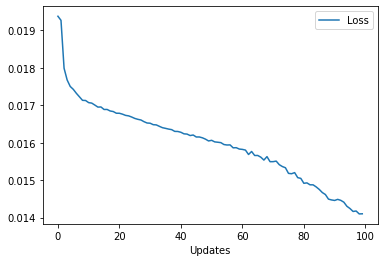

In [ ]:
losses = [loss.cpu().detach().numpy() for loss in losses]
plt.figure()
plt.plot(epoch, losses)
plt.legend(['Loss'])
plt.xlabel('Updates') #, plt.ylabel('')


Then we can plot a confusion matrix to tell how our model performed, and in what mistakes the network made, if any.

Text(0.5, 1.0, '0.41687077275689277')

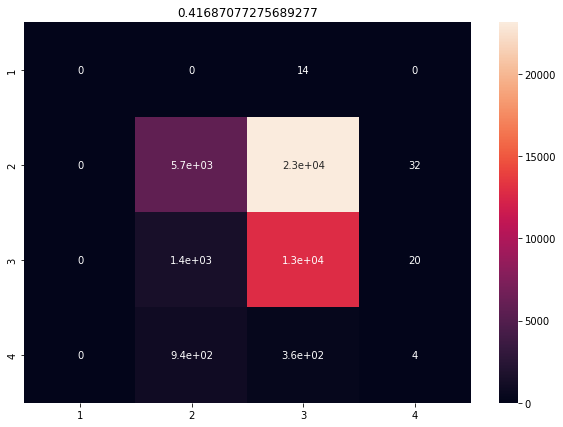

In [ ]:
net.cpu()
preds = torch.max(net(X_test), 1)[1]
cm = confusion_matrix(y_test,preds)
df_cm = pd.DataFrame(cm, index = range(1,5), columns = range(1,5))
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True)
plt.title('Test Accuracy: {}'.format(accuracy_score(y_test,preds)))